In [1]:
from numpy import random
import matplotlib.pyplot as plt

In [2]:
# 固定参数 -- 请勿编辑
# 数据来自： 探讨圣遗物主副词条的分布规律(https://bbs.nga.cn/read.php?tid=25247146)

# 套装掉落概率 -- 平分

# 部件掉落概率 -- 平分
part_names = ['flower', 'plume', 'sand', 'goblet', 'criclet']

# 所需套装每件圣遗物体力价值, 每20体力产出1.067737金圣遗物, 所需套装要乘2
# 圣遗物掉落模型 (https://bbs.nga.cn/read.php?tid=25367618)
cost = 20*2/1.067737

# 初始三词条、四次条比例(来自： https://bbs.nga.cn/read.php?tid=25123729)
initial_features = {'3': 0.83, '4': 0.17} 

# 生之花
# main fixed
flower_sub = {'atk': 0.1579, 'def': 0.1579, 'hp_per': 0.1053, 'atk_per': 0.1053, 'def_per':0.1053, 
              'energy_recharge': 0.1053, 'ele_mastery': 0.1053, 'crit_rate': 0.0789, 'crit_dmg': 0.0789}

# 死之羽
# main fixed
plume_sub = {'hp': 0.1579, 'def': 0.1579, 'hp_per': 0.1053, 'atk_per': 0.1053, 'def_per':0.1053, 
              'energy_recharge': 0.1053, 'ele_mastery': 0.1053, 'crit_rate': 0.0789, 'crit_dmg': 0.0789}

# 时之沙
sand_main = {'hp_per': 0.2667, 'atk_per': 0.2667, 'def_per': 0.2667, 'energy_recharge': 0.1000, 'ele_mastery': 0.1000}
sand_sub = {'hp': 0.15, 'atk': 0.15, 'def': 0.15, 'hp_per': 0.10, 'atk_per': 0.10, 'def_per':0.10, 
              'energy_recharge': 0.10, 'ele_mastery': 0.10, 'crit_rate': 0.075, 'crit_dmg': 0.075}

# 空之杯
goblet_main = {'ele_dmg': 0.05, 'others': 0.95} # others do not count
goblet_sub = {'hp': 0.1364, 'atk': 0.1364, 'def': 0.1364, 'hp_per': 0.0909, 'atk_per': 0.0909, 'def_per':0.0909, 
              'energy_recharge': 0.0909, 'ele_mastery': 0.0909, 'crit_rate': 0.0682, 'crit_dmg': 0.0682}

# 理之冠
criclet_main = {'crit_rate': 0.1, 'crit_dmg': 0.1, 'others': 0.8} # others do not count
criclet_sub = {'hp': 0.1463, 'atk': 0.1463, 'def': 0.1463, 'hp_per': 0.0976, 'atk_per': 0.0976, 'def_per':0.0976, 
              'energy_recharge': 0.0976, 'ele_mastery': 0.0976, 'crit_rate': 0.0732, 'crit_dmg': 0.0732}

part_distributions = {'flower_sub': flower_sub, 'plume_sub': plume_sub, 'sand_main': sand_main, 'sand_sub': sand_sub, 
                     'goblet_main': goblet_main, 'goblet_sub': goblet_sub, 'criclet_main': criclet_main, 'criclet_sub': criclet_sub}

In [3]:
# 随机掉落一个圣遗物, 并计算词条数
def draw_arifact(output = False):
    # 确定部位
    part_type = random.choice(part_names)
    
    # 确定主属性
    part_main = 'default'
    part_type_main = part_type + '_main'
    if part_type_main in part_distributions:
        distribution = part_distributions[part_type_main]
        part_main = random.choice(list(distribution.keys()), p = [i/sum(list(distribution.values())) for i in list(distribution.values())])
        if part_main not in requires[part_type]:
            if output:
                print('主属性不对, 部件：', part_type, '主属性：', part_main)
            return part_type, 0, part_main, None #主属性不对直接放弃

    # 确定副属性
    # 花和羽毛可直接生成副属性,其他需要删除已有主属性
    if part_type == 'flower' or part_type == 'plume':
        distribution_sub = part_distributions[part_type + '_sub']
    else:
        distribution_sub = part_distributions[part_type + '_sub']
        distribution_sub.pop(part_main, None)
    
    part_sub = random.choice(list(distribution_sub.keys()), 4, replace = False, p = [i/sum(list(distribution_sub.values())) for i in list(distribution_sub.values())])
    
    # 先确定强化次数,初始三强化4次,初始四强化5次
    upgrade_times = int(random.choice(list(initial_features.keys()), p = list(initial_features.values())))+1
    
    # 开始强化
    part_upgrade = {i:1 for i in part_sub}
    for t in range(upgrade_times):
        upgrade_loc = random.choice([0,1,2,3])
        part_upgrade[part_sub[upgrade_loc]] += 1
    if output:
        print('部件：', part_type, '主属性：', part_main, '副属性：' , part_upgrade)
    
    score = 0
    for k in part_upgrade.keys():
        score += part_upgrade[k] * sub_attributes_weight[k]
    return part_type, score, part_main, part_upgrade

In [4]:
# 根据最好的圣遗物和散件重新计算最高词条数
def recalculate_score(part_highest_scores):
    s1 = exist_flower_score + part_highest_scores['plume'] + part_highest_scores['sand'] + part_highest_scores['goblet'] + part_highest_scores['criclet']
    s2 = part_highest_scores['flower'] + exist_plume_score + part_highest_scores['sand'] + part_highest_scores['goblet'] + part_highest_scores['criclet']
    s3 = part_highest_scores['flower'] + part_highest_scores['plume'] + exist_sand_score + part_highest_scores['goblet'] + part_highest_scores['criclet']
    s4 = part_highest_scores['flower'] + part_highest_scores['plume'] + part_highest_scores['sand'] + exist_goblet_score + part_highest_scores['criclet']
    s5 = part_highest_scores['flower'] + part_highest_scores['plume'] + part_highest_scores['sand'] + part_highest_scores['goblet'] + exist_criclet_score
    score_list = [s1,s2,s3,s4,s5]
    max_value = max(score_list)
    return max_value, score_list.index(max_value)

# 根据给定目标刷一套圣遗物
def single_single_simulate(target, output = False, exist_set_parts = [0,0,0,0,0]):
    highest_score = 0 # 目前套装最高词条数
    count = 0 # 掉落件数
    part_highest_scores = {'flower': exist_set_parts[0], 'plume': exist_set_parts[1], 'sand': exist_set_parts[2], 'goblet': exist_set_parts[3], 'criclet': exist_set_parts[4]}
    part_highest_main = {'flower': '', 'plume': '', 'sand': '', 'goblet': '', 'criclet': ''}
    part_highest_sub = {'flower': {}, 'plume': {}, 'sand': {}, 'goblet': {}, 'criclet': {}}
    while round(highest_score) < target:
        count += 1
        part_type, score, part_main, part_sub = draw_arifact()
        if score > part_highest_scores[part_type]:
            part_highest_main[part_type] = part_main
            part_highest_sub[part_type] = part_sub
            part_highest_scores[part_type] = score
            highest_score, singlepart_index = recalculate_score(part_highest_scores)    
    if output:
        part_highest_main.pop(part_names[singlepart_index])
        part_highest_sub.pop(part_names[singlepart_index])
        print("共刷了" + str(count) + "件所需套装圣遗物")
        print("散件为" + part_names[singlepart_index])
        print("四件套主属性：", part_highest_main, "\n四件套副属性：", part_highest_sub)
        print("总词条数：", highest_score)
        
    return count, round(highest_score)

# 根据给定的目标进行多次模拟取平均
def single_simulate(target, run_time, exist_set_parts = [0,0,0,0,0]):
    result = []
    for i in range(run_time):
        count, r_h_score = single_single_simulate(target, exist_set_parts = exist_set_parts)
        if r_h_score == target: # 超过目标分数0.5分以上的需要砍掉，否则结果不准确
            result.append(count)
        #print(count)
    return sum(result)/len(result)*cost
                

# 根据不同目标记录模拟结果
def simulation(min_score = 15, max_score = 32, run_time = 1000, exist_set_parts = [0,0,0,0,0]):
    result = []
    x_labels = []
    for i in range(min_score, max_score + 1):
        average_cost = single_simulate(i, run_time, exist_set_parts = exist_set_parts)
        result.append(average_cost)
        x_labels.append(i)
        print("目标词条数：", i, "  平均所需体力：", average_cost)
    
    plt.plot(x_labels, result, marker='o', color='r')
    plt.xlabel('target number of attributes')
    plt.ylabel('average stigma cost')

1. 主要功能示例

目标词条数： 26   平均所需体力： 2218.2094737745692
目标词条数： 27   平均所需体力： 4910.14440554449
目标词条数： 28   平均所需体力： 7515.99931922427
目标词条数： 29   平均所需体力： 12518.788178487148
目标词条数： 30   平均所需体力： 17931.021677353194


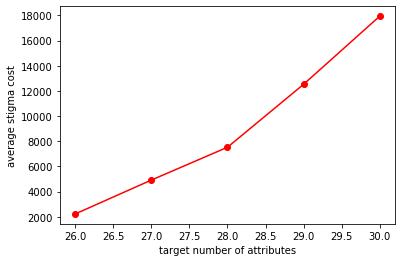

In [5]:
# 玩家定义参数 -- 需要编辑

# 已有相应散件圣遗物词条数，用4件套的前提下，萌新需适当降低。
exist_flower_score = 7
exist_plume_score = 7
exist_sand_score = 6
exist_goblet_score = 5
exist_criclet_score = 4

# 副词条配比，根据自己需要调整，无统一标准，暴击率、暴击伤害一般都算1，其他可计算可估算
sub_attributes_weight = {'hp': 0, 'atk': 0.3, 'def': 0, 'hp_per': 0, 'atk_per': 1, 'def_per':0, 
              'energy_recharge': 0, 'ele_mastery': 0.5, 'crit_rate': 1, 'crit_dmg': 1}

# 主属性需求
sand_require = set(['atk_per'])
goblet_require = set(['ele_dmg'])
criclet_require = set(['crit_dmg'])
requires = {'sand': sand_require, 'goblet': goblet_require, 'criclet': criclet_require}

# 模拟1000次刷圣遗物所需体力 
# exist_set_parts为已有套装圣遗物词条分数 (e.g.[花，羽毛，沙漏，杯，头]=[6,6,3,3,4])，默认为全0
# 当前我的圣遗物已经达到25词条，因此从26开始
simulation(min_score = 26, max_score = 30, exist_set_parts=[6,6,3,3,4])

2. 娱乐以及子函数功能

In [6]:
# 玩家定义参数 -- 需要编辑

# 已有相应散件圣遗物词条数，用4件套的前提下，萌新需适当降低。
exist_flower_score = 7
exist_plume_score = 7
exist_sand_score = 6
exist_goblet_score = 5
exist_criclet_score = 4

# 副词条配比，根据自己需要调整，无统一标准，暴击率、暴击伤害一般都算1，其他可计算可估算
sub_attributes_weight = {'hp': 0, 'atk': 0.3, 'def': 0, 'hp_per': 0, 'atk_per': 1, 'def_per':0, 
              'energy_recharge': 0, 'ele_mastery': 0.5, 'crit_rate': 1, 'crit_dmg': 1}

# 主属性需求
sand_require = set(['atk_per'])
goblet_require = set(['ele_dmg'])
criclet_require = set(['crit_dmg'])
requires = {'sand': sand_require, 'goblet': goblet_require, 'criclet': criclet_require}

In [7]:
# 模拟刷一套圣遗物, 娱乐向
single_single_simulate(30, output=True, exist_set_parts=[6,6,3,3,4])

共刷了570件所需套装圣遗物
散件为goblet
四件套主属性： {'flower': 'default', 'plume': '', 'sand': 'atk_per', 'criclet': 'crit_dmg'} 
四件套副属性： {'flower': {'atk_per': 2, 'atk': 1, 'crit_rate': 3, 'crit_dmg': 2}, 'plume': {}, 'sand': {'energy_recharge': 2, 'def': 1, 'crit_dmg': 2, 'crit_rate': 4}, 'criclet': {'def_per': 1, 'def': 1, 'crit_rate': 2, 'atk_per': 4}}
总词条数： 30.3


(570, 30)

In [8]:
# 所需体力期望, 自己设定目标，模拟次数
print("所需体力期望：", single_simulate(30, 1000, exist_set_parts=[6,6,3,3,4]))

所需体力期望： 18689.371383901966


3. 从0开始刷结果示例两个

目标词条数： 15   平均所需体力： 502.0138249053818
目标词条数： 16   平均所需体力： 607.9217345662172
目标词条数： 17   平均所需体力： 765.6234972492985
目标词条数： 18   平均所需体力： 922.336525028728
目标词条数： 19   平均所需体力： 1180.252815813635
目标词条数： 20   平均所需体力： 1378.1129481079604
目标词条数： 21   平均所需体力： 1753.9402101535875
目标词条数： 22   平均所需体力： 2114.2100852917433
目标词条数： 23   平均所需体力： 2749.63817022254
目标词条数： 24   平均所需体力： 3314.1922723345865
目标词条数： 25   平均所需体力： 4614.044565954943
目标词条数： 26   平均所需体力： 5645.040011258067
目标词条数： 27   平均所需体力： 8258.436840993036
目标词条数： 28   平均所需体力： 11558.030458951862
目标词条数： 29   平均所需体力： 17666.91035469047
目标词条数： 30   平均所需体力： 25884.18042632121
目标词条数： 31   平均所需体力： 44693.69433775463
目标词条数： 32   平均所需体力： 70150.01267237638


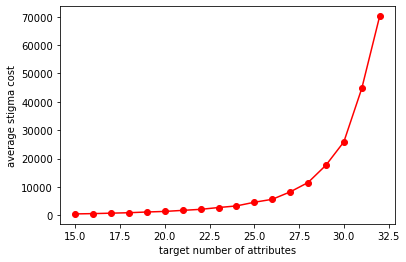

In [8]:
# 优菈

# 玩家定义参数 -- 需要编辑

# 已有相应散件圣遗物词条数，用4件套的前提下，萌新需适当降低。
exist_flower_score = 7
exist_plume_score = 7
exist_sand_score = 4
exist_goblet_score = 5
exist_criclet_score = 4

# 副词条配比，根据自己需要调整，无统一标准，暴击率、暴击伤害一般都算1，其他可计算可估算
sub_attributes_weight = {'hp': 0, 'atk': 0.3, 'def': 0, 'hp_per': 0, 'atk_per': 1, 'def_per':0, 
              'energy_recharge': 0.5, 'ele_mastery': 0, 'crit_rate': 1, 'crit_dmg': 1}

# 主属性需求
sand_require = set(['atk_per'])
goblet_require = set(['ele_dmg'])
criclet_require = set(['crit_rate', 'crit_dmg'])
requires = {'sand': sand_require, 'goblet': goblet_require, 'criclet': criclet_require}

# 模拟1000次刷圣遗物所需体力 
simulation()

In [ ]:
# 胡桃

# 玩家定义参数 -- 需要编辑

# 已有相应散件圣遗物词条数，用4件套的前提下，萌新需适当降低。
exist_flower_score = 7
exist_plume_score = 7
exist_sand_score = 4
exist_goblet_score = 5
exist_criclet_score = 4

# 副词条配比，根据自己需要调整，无统一标准，暴击率、暴击伤害一般都算1，其他可计算可估算
sub_attributes_weight = {'hp': 0.3, 'atk': 0.3, 'def': 0, 'hp_per': 1, 'atk_per': 0.5, 'def_per':0, 
              'energy_recharge': 0, 'ele_mastery': 1, 'crit_rate': 1, 'crit_dmg': 1}

# 主属性需求
sand_require = set(['hp_per', 'ele_mastery'])
goblet_require = set(['ele_dmg'])
criclet_require = set(['crit_rate', 'crit_dmg'])
requires = {'sand': sand_require, 'goblet': goblet_require, 'criclet': criclet_require}


# 模拟1000次刷圣遗物所需体力
simulation(max_score = 35)

目标词条数： 15   平均所需体力： 279.13385321170495
目标词条数： 16   平均所需体力： 341.78570049902163
目标词条数： 17   平均所需体力： 414.2958185011612
目标词条数： 18   平均所需体力： 484.17673559399395
目标词条数： 19   平均所需体力： 568.266585553614
目标词条数： 20   平均所需体力： 671.6995323565321
目标词条数： 21   平均所需体力： 804.1704407889316
目标词条数： 22   平均所需体力： 901.3098775839975
目标词条数： 23   平均所需体力： 1112.1602479645662
目标词条数： 24   平均所需体力： 1375.9991230057021
目标词条数： 25   平均所需体力： 1687.6358312132998
目标词条数： 26   平均所需体力： 2050.0717873408903
目标词条数： 27   平均所需体力： 2587.431763827125
目标词条数： 28   平均所需体力： 3282.940592113366
目标词条数： 29   平均所需体力： 4471.456569025433
目标词条数： 30   平均所需体力： 6187.651003569222
目标词条数： 31   平均所需体力： 8956.164077386233
目标词条数： 32   平均所需体力： 12621.383525922753
目标词条数： 33   平均所需体力： 20771.56444071393
目标词条数： 34   平均所需体力： 32056.696499534974
